# Twisted particle filters with linear Gaussian state-space models
The filtering problem is to estimate $p(x_{t} \mid y_{1:t})$.
The smoothing problem is to estimate $p(x_{1:T} \mid y_{1:T})$
For a linear Gaussian state-space model, these can be computed exactly using a Kalman filter and an RTS-smoother.

For non-linear problem, the Kalman filter and RTS-smoother can be approxiamted using eg. linearisation or propogation of sigma points. However, these approximations introduce bia and can be arbitrality bad.

Sequential Monte Carlo performs approximate inference by approximating the distributions with a weighted set of particles.  These particles are propagated forward be the transition function and the weights are updated be the observation functoin.

In system identification, an offline setting is most common and the smoothing distribution is of interest.
The ordinary particle filter targets sequentially the filter distribution $p[x_{1:t} \mid y_{1:t})$.
By introducing extra potential functions, the filter can twist the filter densitties to bettwr align with what is really of interest $p(x_{1:t} \mid y_{1:T})$.

In this notebook, we investigate how a Kalman filter and RTS-smoother can be combined with the particle filter through the potentials to increase performance.

In [1]:
using Revise
using SequentialMonteCarlo
using SequentialMonteCarlo: states, weights
using StaticArrays
using PDMats
using Random
using Distributions
using StatsPlots
using DataFrames
using ProgressMeter

Random.seed!(42)

┌ Info: Precompiling SequentialMonteCarlo [f9b7e06c-507a-49e7-80c8-92078bbfddc7]
└ @ Base loading.jl:1317


MersenneTwister(42)

A general linear Gaussian state-space model can be written as
$$
\begin{align}
    x_{t+1} &= Ax_{t} + Bu_{t} + v_{t}, \\
y_{t} &= Cx_{t} + e_{t}, \\
x_{1} &\sim \mathcal{N}(\mu_{1}, \Sigma_{1}),\; v_{t} \sim \mathcal{N}(0, Q),\; e_{t} \sim \mathcal{N}(0,R).
\end{align}
$$
Let us define a simple two dimensional system with one input and one output.


In [2]:
# Define a linear Gaussian model
nx = 2  # State space dimension
nu = 1  # Input dimension
ny = 1  # Output dimension
model = LinearGaussian{nx,ny,nu}();

Let
$$
\begin{align}
    A &= \begin{bmatrix} 0.3 & 0.05 \\ 0.0 & 0.99 \end{bmatrix} &&&
    B &= \begin{bmatrix} 0 \\1 \end{bmatrix} &&&
    Q &= \begin{bmatrix}10 & 0 \\ 0 & 0.1 \end{bmatrix} &&&
    \mu_{0} &= \begin{bmatrix} 0 \\ 0 \end{bmatrix}\\
    C &= \begin{bmatrix} 1 & 0 \end{bmatrix} &&&
    D &= 0 &&&
    R&= \begin{bmatrix} 1 \end{bmatrix} &&&
    \Sigma_{0} &= \begin{bmatrix} 10 & 0 \\ 0 & 100 \end{bmatrix}   
\end{align}
$$

In [3]:
# Set parameters.
θ = LinearGaussianPar(
    A = (@SMatrix [0.3 0.05; 0.0 0.99]),
    B = (@SMatrix [0.0 ; 1.0]),
    C = (@SMatrix [1.0 0.0]),
    Q = (@SMatrix [10.0 0.0; 0.0 0.1]) |> PDMat,
    R = (@SMatrix [1.0])|> PDMat,
    μ₀ = (@SVector [0.0, 0.0]),
    Σ₀ = (@SMatrix [10.0 0.0; 0.0 200.0]) |> PDMat);
# D default to 0

Let us use simulated data with $T = 200$ observations a sinudoid with decaying amplitude with added random noise as input.

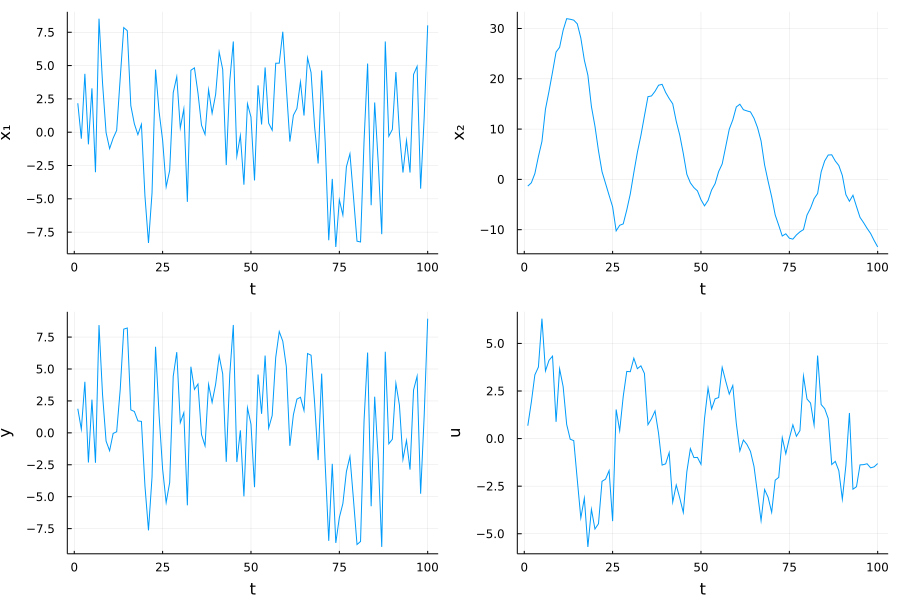

In [4]:
T = 100
# Simulate data. The input is a sinusoid with decreasing amplitude
data = (;u = [5.0*exp(-0.01*i)*sin(0.04*2π*i) .+ randn(SVector{nu, Float64}) for i in 1:T])
y, x = simulate(model, data, θ, T);
data = (;u=data.u, y); # We need this data structure later for filtering

# Plot the simulated data
x_plot = reinterpret(reshape, Float64, toSVector.(x))' |> copy
y_plot = reinterpret(reshape, Float64, SVector.(data.y)) |> copy
u_plot = reinterpret(reshape, Float64, SVector.(data.u)) |> copy

# l = @layout [grid(1,2); b{0.5h}]
px1 = plot(x_plot[:,1], lab="", ylabel="x₁", xlabel="t")
px2 = plot(x_plot[:,2], lab="", ylabel="x₂", xlabel="t")
py = plot(y_plot, lab="", ylabel="y", xlabel="t")
pu = plot(u_plot, lab="", ylabel="u", xlabel="t")
plot(px1, px2, py, pu, layout=(2,2),size=(900,600), fmt=:png)

## Run Kalman filter and RTS-smother
Using the model and data, we can now run a Kalman filter and a RTS smoother.

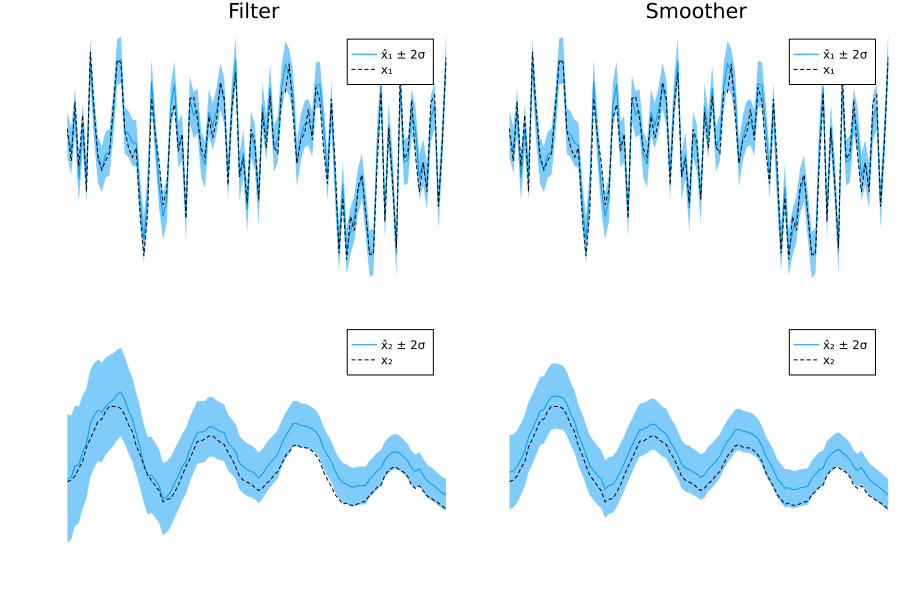

In [5]:
# Crreate and run an RTS-smoother. This runs the Kalman filter first and then a backwards smoothing pass 
rts = RtsSmoother(model, data)
rts(θ)

# Compute filter and smoothing means and standard deviations.
x̂ = reduce(hcat, mean.(filter_density(rts)))' |> copy
σ = sqrt.(reduce(hcat, var.(filter_density(rts)))')
x̂ₛ = reduce(hcat, mean.(smoothing_density(rts)))' |> copy
σₛ = sqrt.(reduce(hcat, var.(smoothing_density(rts)))');

# Compute range for consistant x and y axis.
ymax = maximum(x̂, dims=1) .+ 1.1*2 .* maximum(σ, dims=1)
ymin = minimum(x̂, dims=1) .- 1.1*2 .* maximum(σ, dims=1)
yl = ((ymin[1],ymax[1]),(ymin[2],ymax[2]))

# Extract and plot filter mean and standard deviation
p1 = plot(x̂[:,1], ribbon=2*σ[:,1], lab="x̂₁ ± 2σ", ylim=yl[1], ylabel="x₁", border=:none)
plot!(p1, x_plot[:,1], c="black", ls=:dash, lab="x₁")
p2 = plot(x̂[:,2], ribbon=2*σ[:,2], lab="x̂₂ ± 2σ", ylim=yl[2], ylabel="x₂", border=:none)
plot!(p2, x_plot[:,2], c="black", ls=:dash, lab="x₂")
p3 = plot(x̂ₛ[:,1], ribbon=2*σₛ[:,1], lab="x̂₁ ± 2σ", ylim=yl[1], border=:none)
plot!(p3, x_plot[:,1], c="black", ls=:dash, lab="x₁")
p4 = plot(x̂ₛ[:,2], ribbon=2*σₛ[:,2], lab="x̂₂ ± 2σ", ylim=yl[2], border=:none)
plot!(p4, x_plot[:,2], c="black", ls=:dash, lab="x₂")

plot(p1,p3,p2,p4,
    layout=(2,2),
    size=(900,600),
    title=["Filter" "Smoother" "" ""],
    xlim=(0, T),
#    fmt=:png
)

## Bootstrap particle filter
Let's try to do the same using a particle filter.

First we look at the filter distribtuions $p(x_{t} \mid t_{1:t})$.

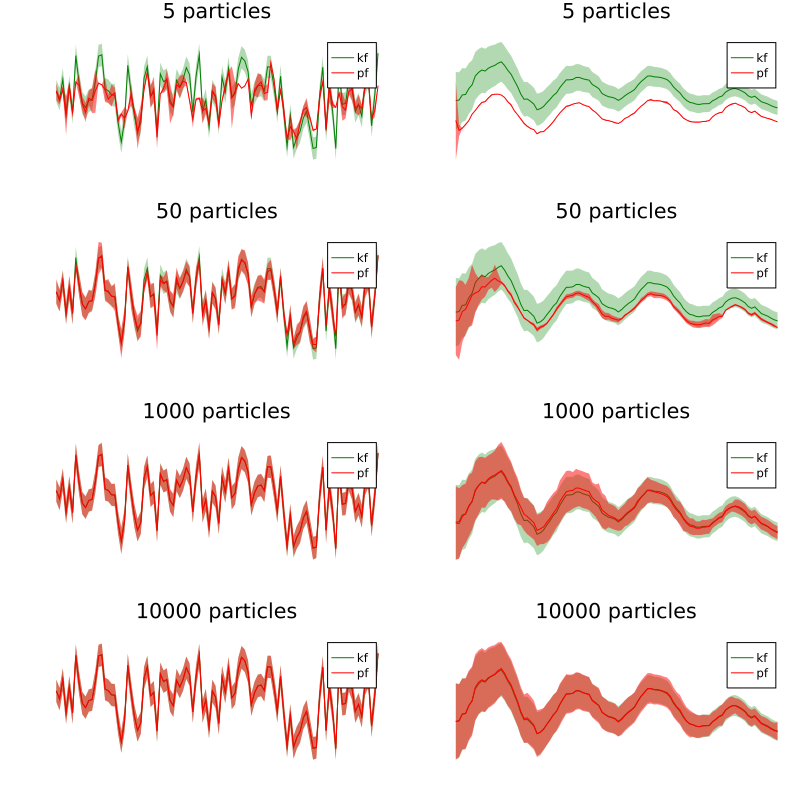

In [6]:
# Define a bootstrap particle filter with 10_000 particles
pf = ParticleFilter(model, 10_000, data)

n_particles = [5, 50, 1_000, 10_000]
XX = [Matrix{Float64}(undef, T, 2) for _ ∈ n_particles]
ΣΣ = [Matrix{Float64}(undef, T, 2) for _ ∈ n_particles]
for (i, n) ∈ enumerate(n_particles)
    pf.storage.n_particles[] = n # Ugly! Should export a suitable function.
    run_filter!(pf, θ)
    XX[i] .= reinterpret(reshape, Float64, sum(toSVector.(states(pf)) .* exp.(weights(pf)[:,1:end-1]), dims=1) |> vec)' |> copy
    ΣΣ[i] .= sqrt.(reinterpret(reshape, Float64, sum(map(x->x.*x, toSVector.(states(pf)) .- reinterpret(SVector{2,Float64}, XX[i]')).*exp.(weights(pf)[:,1:end-1]), dims=1) |> vec)')
end
pp = []
for (i, n) in enumerate(n_particles)
    p1 = plot(x̂[:,1], ribbon=2*σ[:,1],c="green",fillalpha=0.3, lab="kf", title="$n particles",border=:none)
    plot!(p1, XX[i][:,1], ribbon=2*ΣΣ[i][:,1], c="red", fillaplpha=0.3, lab="pf")
    p2 = plot(x̂[:,2], ribbon=2*σ[:,2],c="green",fillalpha=0.3, lab="kf",title="$n particles", border=:none)
    plot!(p2, XX[i][:,2], ribbon=2*ΣΣ[i][:,2], c="red", fillaplpha=0.3, lab="pf")
    push!(pp, p1)
    push!(pp, p2)
end
plot(pp..., layout=(length(n_particles),2),size=(800,800),fmt=:png)

## Locally optimal proposal
Let's try again with a locally optimal proposal

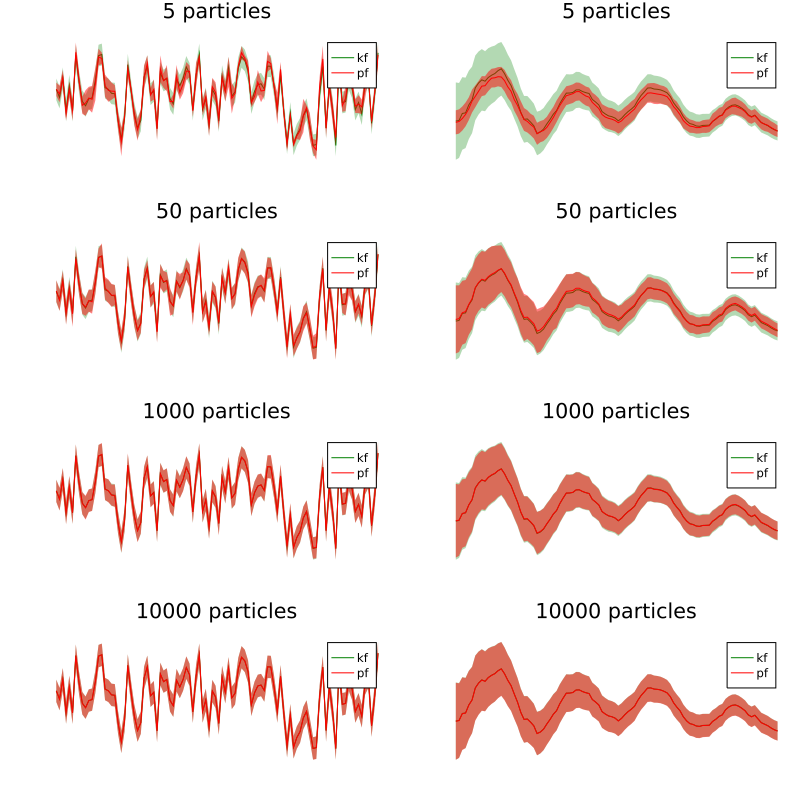

In [7]:
# Define a bootstrap particle filter with 10_000 particles
proposal = LocallyOptimalProposal(model, KalmanFilter)
pf_lo = ParticleFilter(pf, proposal=proposal) # Note that pf and pf_lo shares the same storage

n_particles = [5, 50, 1_000, 10_000]
XX_lo = [Matrix{Float64}(undef, T, 2) for _ ∈ n_particles]
ΣΣ_lo = [Matrix{Float64}(undef, T, 2) for _ ∈ n_particles]
for (i, n) ∈ enumerate(n_particles)
    pf_lo.storage.n_particles[] = n # Ugly! Should export a suitable function.
    run_filter!(pf_lo, θ)
    XX_lo[i] .= reinterpret(reshape, Float64, sum(toSVector.(states(pf_lo)) .* exp.(weights(pf_lo)[:,1:end-1]), dims=1) |> vec)' |> copy
    ΣΣ_lo[i] .= sqrt.(reinterpret(reshape, Float64, sum(map(x->x.*x, toSVector.(states(pf_lo)) .- reinterpret(SVector{2,Float64}, XX_lo[i]')).*exp.(weights(pf_lo)[:,1:end-1]), dims=1) |> vec)')
end
pp_lo = []
for (i, n) in enumerate(n_particles)
    p1 = plot(x̂[:,1], ribbon=2*σ[:,1],c="green",fillalpha=0.3, lab="kf", title="$n particles",border=:none)
    plot!(p1, XX_lo[i][:,1], ribbon=2*ΣΣ_lo[i][:,1], c="red", fillaplpha=0.3, lab="pf")
    p2 = plot(x̂[:,2], ribbon=2*σ[:,2],c="green",fillalpha=0.3, lab="kf", title="$n particles", border=:none)
    plot!(p2, XX_lo[i][:,2], ribbon=2*ΣΣ_lo[i][:,2], c="red", fillaplpha=0.3, lab="pf")
    push!(pp_lo, p1)
    push!(pp_lo, p2)
end
plot(pp_lo..., layout=(length(n_particles),2),size=(800,800),fmt=:png)

## Likelihood estimator
The partifcle filter also provides unbiased estimates of the likelihood.
Since we are not interested in keeping all states, we can run a slim particle filter which only allocates particles for two tim instances instead of all.
This allows us to run with more particles and for a basically unlimited number of iterations (at least memory wise).

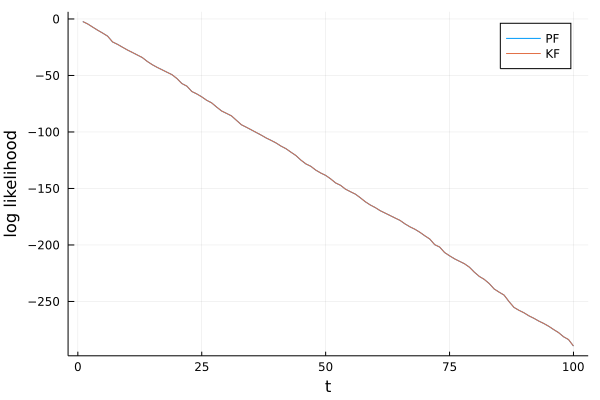

In [8]:
# Let's allocate for a million particles
slim_pf = ParticleFilter(model, 1_000_000, data,
    storage=SlimParticleStorage,
    resampler=ResampleWithESSThreshold(MultinomialResampler()))
# Run filter to estimate likelihood
run_filter!(slim_pf, θ)
plot(slim_pf.storage.ll, lab="PF", ylabel="log likelihood", xlabel="t")
plot!(rts.storage.ll, lab="KF")

Running a bootstrap filter with a million particles follows the true value almost exactly for att $t$.
This is just to establish a baseline.
We know we can get close to the true value with a bootstrap particle filter and a million particles.
Let's now try a few other approaches.

The particle filter produces unbiased estimates of the likelihood for any number of particles.
In the boxplots below, the log likelihood is plotted.
Since the logarithm is concave, the variance of the estimated likelihoods is tranlated to a negative bias for the log likelihood.
Hence, the variance of the likelihood estimates are reflected in _both_ the variance of the log likelihood estiamtes as well as the bias.
Im tjhe plots, a higher value is in general better.

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


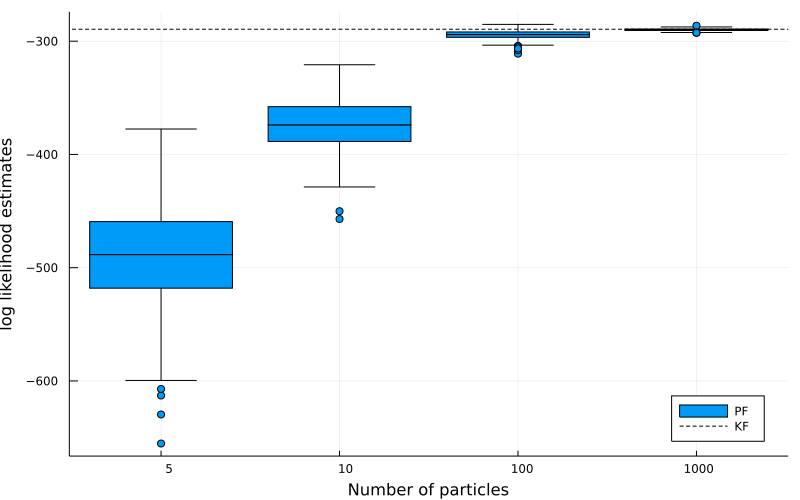

In [9]:
# Estimate using bootstrap with vaying number of particles
M = 500
# We use a dataframe to store the results

df = DataFrame(method=String[], particles=Int[],likelihood = Vector{Float64}[])
n_particles = [5, 10, 100, 1_000]
@showprogress for n ∈ reverse(n_particles)
    slim_pf.storage.n_particles[] = n
    ll = [(run_filter!(slim_pf, θ); slim_pf.storage.ll[end]) for _ ∈ 1:M]
    push!(df, ["bootstrap", n, ll])
end
df_plot = transform(combine(
    DataFrames.groupby(df,
        [:method, :particles]),
        :likelihood => (x->reduce(vcat,x)),
        renamecols=false),
    :particles => ByRow(x->lpad(string(x), 5)) => :particles_string)

p = @df df_plot boxplot(:particles_string, :likelihood, lab="PF", legend=:bottomright, size=(800,500),ylabel="log likelihood estimates", xlabel="Number of particles")
plot!(p, [rts.storage.ll[end]], linetype=:hline,ls=:dash,lc=:black, lab="KF")

By twisting the target, we can now aim directly for the final target and likelihood by utilizing the Kalman filter to compute potentials and the RTS-smoother to also compute the optimal proposal.

Using the optimal potential together with the optimal proposal gives correct likelihood estimate with propability 1.

For a linear Gaussian state-space model, both the optimal proposal and optimal potential are tractable.

In [10]:
proposal = RTSProposal(rts)
potential = RTSPotential(rts)
SequentialMonteCarlo.init!(proposal, θ) # Pre-compute

pf_pot = ParticleFilter(slim_pf, potential=potential)
pf_prop = ParticleFilter(slim_pf, proposal=proposal)
pf_opt = ParticleFilter(slim_pf, potential=potential, proposal=proposal)
pf_lo = ParticleFilter(slim_pf, proposal=LocallyOptimalProposal(model))
pf_lo_pot = ParticleFilter(slim_pf, proposal=LocallyOptimalProposal(model), potential=potential)

all_pf = [pf_pot, pf_prop, pf_opt, pf_lo, pf_lo_pot]
pf_names = ["pot", "prop", "opt", "lo", "lo-pot"]
@showprogress for (name,f) ∈ zip(pf_names, all_pf)
    for n ∈ reverse(n_particles)
        f.storage.n_particles[] = n
        ll = [(run_filter!(f, θ); f.storage.ll[end]) for _ ∈ 1:M]
        push!(df, [name, n, ll])
    end
end

df_plot = transform(combine(
    DataFrames.groupby(df,
        [:method, :particles]),
        :likelihood => (x->reduce(vcat,x)),
        renamecols=false),
    :particles => ByRow(x->lpad(string(x), 4)) => :particles_string);


Progress: 100%|█████████████████████████████████████████| Time: 0:01:01


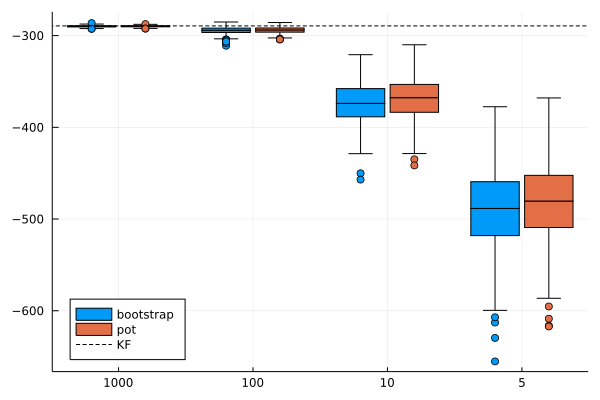

In [11]:
ddf = filter(row->row.method=="bootstrap" || row.method=="pot", df_plot)
@df ddf groupedboxplot(string.(:particles), :likelihood, group=:method, legend=:bottomleft)
plot!([rts.storage.ll[end]], linetype=:hline,ls=:dash,lc=:black, lab="KF")

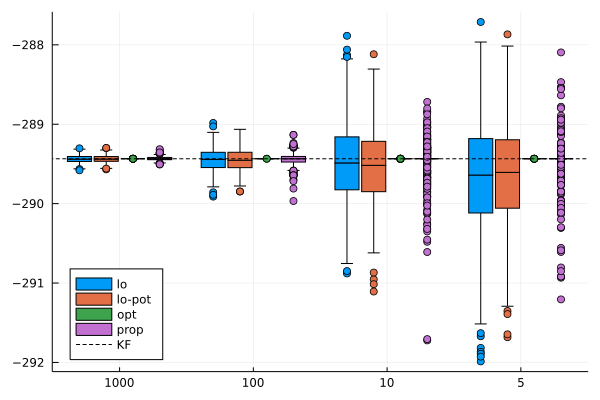

In [12]:
@df filter(row->!(row.method == "bootstrap" || row.method == "pot"), df_plot) groupedboxplot(string.(:particles), :likelihood, group=:method, legend=:bottomleft)
plot!([rts.storage.ll[end]], linetype=:hline,ls=:dash,lc=:black, lab="KF")

## Smoothing
Lets look at targeting the smoothing density using conditoinal particle filter.
One interesting metric is the update frequency that measures how often a particle at a certain time index is updated.
We also compute sufficient statisticts to verfiy that the filters are actually targeting the smoothing density.

In [243]:
pf = ParticleFilter(model, 1000, data)

rts_proposal = RTSProposal(rts)
rts_potential = RTSPotential(rts)
lo_proposal = LocallyOptimalProposal(model)
SequentialMonteCarlo.init!(rts_proposal, θ) # Pre-compute

cpf = ConditionalParticleFilter(pf)
cpf_pot = ConditionalParticleFilter(pf, potential=rts_potential)
cpf_prop = ConditionalParticleFilter(pf, proposal=rts_proposal)
cpf_opt = ConditionalParticleFilter(pf, proposal=rts_proposal, potential=rts_potential)
cpf_lo = ConditionalParticleFilter(pf, proposal=lo_proposal)
cpf_lo_pot = ConditionalParticleFilter(pf, proposal=lo_proposal, potential=rts_potential)

acpf = ConditionalParticleFilterWithAncestorSampling(pf)
acpf_pot = ConditionalParticleFilterWithAncestorSampling(pf, potential=potential)
acpf_prop = ConditionalParticleFilterWithAncestorSampling(pf, proposal=proposal)
acpf_opt = ConditionalParticleFilterWithAncestorSampling(pf, proposal=proposal, potential=potential)
acpf_lo = ConditionalParticleFilterWithAncestorSampling(pf, proposal=lo_proposal)
acpf_lo_pot = ConditionalParticleFilterWithAncestorSampling(pf, proposal=lo_proposal, potential=rts_potential)

all_cpf = [cpf, cpf_pot,cpf_prop, cpf_opt, cpf_lo, cpf_lo_pot, acpf, acpf_pot, acpf_prop, acpf_opt, acpf_lo, acpf_lo_pot]
names_cpf = ["CPF" "CPF-POT" "CPF-PROP" "CPF-OPT" "CPF-LO" "CPF-LO-POT" "CPF-AS" "CPF-AS-POT" "CPF-AS-PROP" "CPF-AS-OPT" "ACPF-LO" "ACPF-LO-POT"]
# Since the conditoinal particle filter and the bootstrap shares storage, we initialize
# by running the nonconditional filter.
run_filter!(pf, θ)
SequentialMonteCarlo.finalize!(cpf, θ) # Sample reference and condition

# Burn-in
@showprogress "Burn-in" for _ ∈ 1:100
    run_filter!(acpf, θ)
end

M = 1000
n_particles = [2, 5, 10, 20, 50,]
x_ref = reference(cpf)
x_old = toSVector.(x_ref)

updates = [zeros(Float64, length(x_old), length(all_cpf)) for _ ∈ 1:length(n_particles)]
mean_x = [zeros(Float64, length(x_old), 2, length(all_cpf)) for _ ∈ 1:length(n_particles)]
sqr_x = [zeros(Float64, length(x_old), 2, length(all_cpf)) for _ ∈ 1:length(n_particles)]

@showprogress for (k,cf) ∈ enumerate(all_cpf)
    for (i,n) ∈ enumerate(n_particles)
        pf.storage.n_particles[] = n
        for m ∈ 1:M
            run_filter!(cf, θ)
            xx = toSVector.(x_ref)
            updates[i][:,k] .+= (x_old .!== xx)./M
            mean_x[i][:,:,k] .+= reinterpret(reshape, Float64, xx)'./M
            sqr_x[i][:,:,k] .+= (reinterpret(reshape, Float64, xx)'.^2) ./M
            x_old = xx
        end
    end
end
    


Burn-in100%|████████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:22


## Update frequency

First let's plot the update frequency for a bunch of filters for different number of particles.

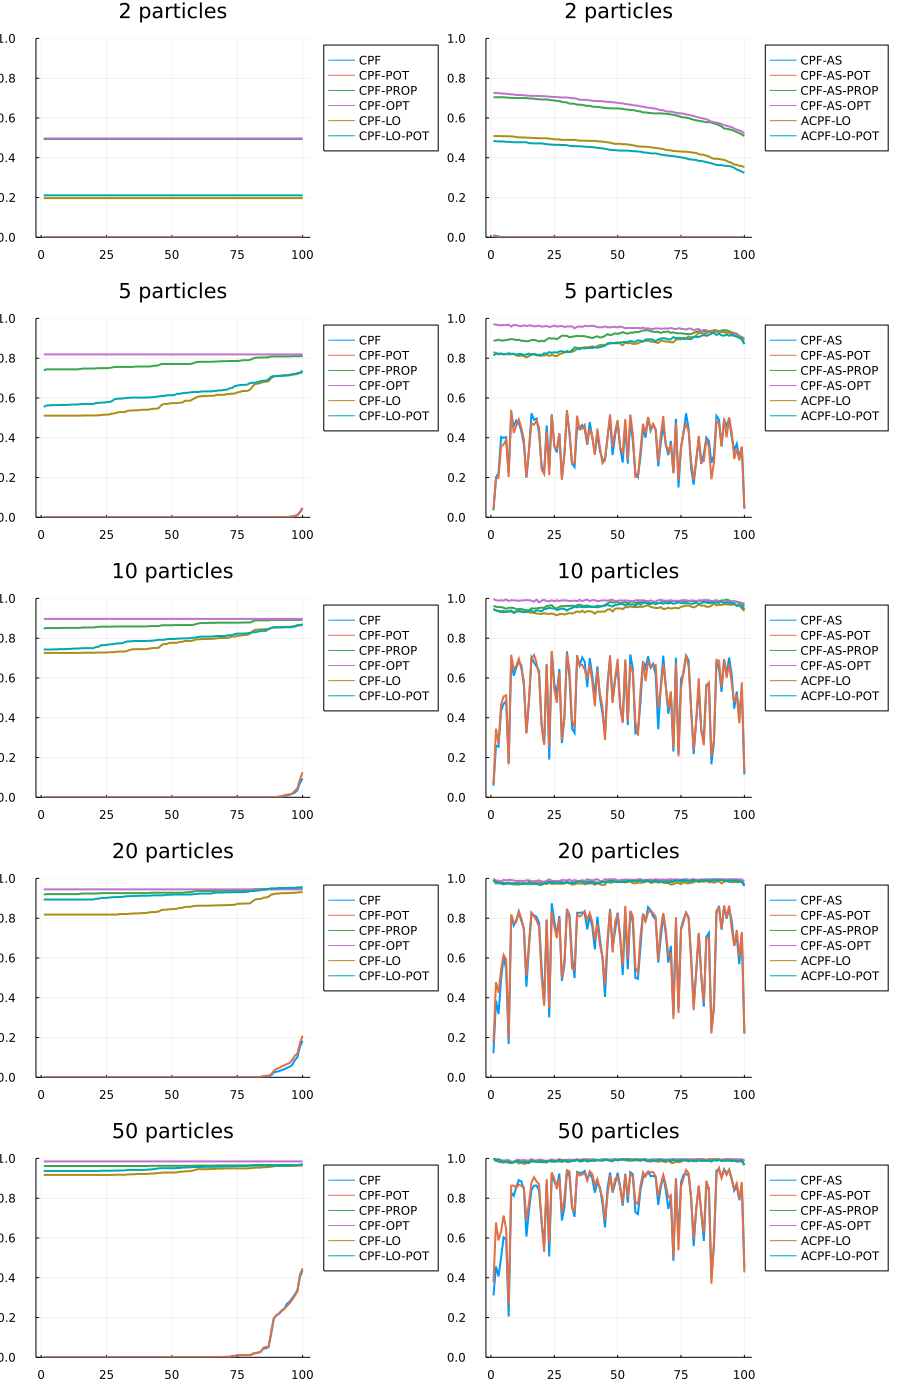

In [392]:
all_plots = []
for nn in 1:length(n_particles)
    p_cpf = plot(updates[nn][:,1:6],
        lab=names_cpf[:,1:6],
        legend=:outertopright,
        title="$(n_particles[nn]) particles")
    p_acpf = plot(updates[nn][:,7:12],
        lab=names_cpf[:,7:12],
        legend=:outertopright,
        title="$(n_particles[nn]) particles")

    push!(all_plots, plot(p_cpf, p_acpf, layout=(1,2), ylim=(0.0,1.0), lw=2))
end
plot(all_plots..., layout=(5,1), size=(900, 1400))

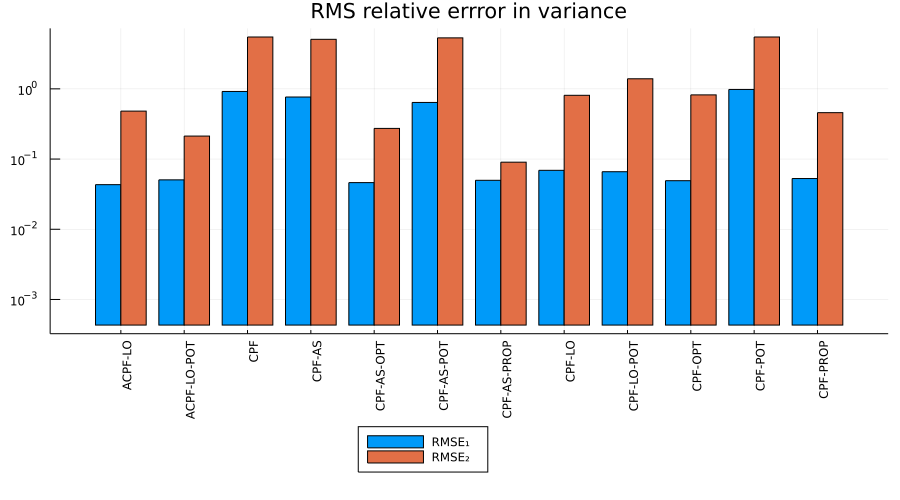

In [444]:
dff = DataFrame(sqrt.(dropdims(mean(((sqr_x[nn] .- mean_x[nn].^2) .- σₛ.^2).^2 ./ σₛ.^2, dims=1), dims=1)'), ["RMSE₁","RMSE₂"])
dff.method = names_cpf |> vec


@df stack(dff) groupedbar(:method, :value, group=:variable,
    size=(900,500),
    yaxis=:log,
    legend=:outerbottom,
    bar_position=:dodge,
    xrotation=90,
    title="RMS relative errror in variance")